Seizure detection using electroencephalography

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import scipy.signal as signal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

The function below (load_data) loads the required data from two folders, seizure and nonseizure. It then labels each one with 0 (nonseizure) or 1(seizure). This ensures that the data is organized and labeled before preprocessing or feeding it to our model.
The function explore_sample_data visualizes 4 second data of one file from each label. 

In [4]:
# Paths to the data folders
nonseizure_folder = 'data/nonseizure/'
seizure_folder = 'data/seizure/'

# Function to load all data files and create labels
def load_data(nonseizure_path, seizure_path):
    """
    Load all EEG data files from nonseizure and seizure folders
    
    Parameters:
    nonseizure_path (str): Path to nonseizure data folder
    seizure_path (str): Path to seizure data folder
    
    Returns:
    all_data (list): List of dataframes containing EEG data
    all_labels (np.array): Array of labels (0 for nonseizure, 1 for seizure)
    """
    print("Loading data files...")
    
    # Load non-seizure files
    nonseizure_files = glob(os.path.join(nonseizure_path, '*.csv'))
    print(f"Found {len(nonseizure_files)} non-seizure files")
    nonseizure_data = []
    for file in nonseizure_files:
        try:
            df = pd.read_csv(file)
            nonseizure_data.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    # Load seizure files
    seizure_files = glob(os.path.join(seizure_path, '*.csv'))
    print(f"Found {len(seizure_files)} seizure files")
    seizure_data = []
    for file in seizure_files:
        try:
            df = pd.read_csv(file)
            seizure_data.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    # Create labels (0 for non-seizure, 1 for seizure)
    nonseizure_labels = np.zeros(len(nonseizure_data))
    seizure_labels = np.ones(len(seizure_data))
    
    # Combine data and labels
    all_data = nonseizure_data + seizure_data
    all_labels = np.concatenate([nonseizure_labels, seizure_labels])
    
    print(f"Total samples: {len(all_data)} ({len(nonseizure_data)} non-seizure, {len(seizure_data)} seizure)")
    
    return all_data, all_labels

def explore_sample_data(nonseizure_file, seizure_file):
    """
    Explore and visualize sample EEG data files
    
    Parameters:
    nonseizure_file (str): Path to a sample non-seizure file
    seizure_file (str): Path to a sample seizure file
    
    Returns:
    nonseizure_df, seizure_df: Sample dataframes
    """
    # Load sample files
    print("\n--- Data Exploration ---")
    nonseizure_df = pd.read_csv(nonseizure_file)
    seizure_df = pd.read_csv(seizure_file)
    
    # Print basic information
    print(f"\nNon-seizure file shape: {nonseizure_df.shape}")
    print(f"Seizure file shape: {seizure_df.shape}")
    print(f"\nEEG channels: {nonseizure_df.columns.tolist()}")
    
    # Plot sample data from both classes
    plt.figure(figsize=(15, 10))
    
    # Plot non-seizure data
    plt.subplot(2, 1, 1)
    channel = nonseizure_df.columns[0]  # First EEG channel
    plt.plot(nonseizure_df[channel][:1024])  # 4 seconds of data (at 256 Hz)
    plt.title(f'Non-seizure EEG data (channel {channel})')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Plot seizure data
    plt.subplot(2, 1, 2)
    plt.plot(seizure_df[channel][:1024], color='red')  # 4 seconds of data
    plt.title(f'Seizure EEG data (channel {channel})')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('eeg_sample_comparison.png')
    plt.close()
    
    return nonseizure_df, seizure_df


Applying a bandpass filter to the EEG data, keeping only frequencies between 0.5 Hz and 40 Hz while removing everything else. Filtering help reduce noise that could come from muscle movement, blinking etc. This makes it possible to focus on relevant data between 0.5-40 Hz.

In [6]:
def preprocess_eeg(data, fs=256):
    """
    Preprocess EEG data by applying bandpass filtering
    
    Parameters:
    data (pd.DataFrame): EEG data
    fs (int): Sampling frequency in Hz
    
    Returns:
    filtered_data (pd.DataFrame): Filtered EEG data
    """
    # Define filter parameters for commonly used EEG frequency bands (0.5-40 Hz)
    lowcut = 0.5  # Hz
    highcut = 40  # Hz
    
    # Create bandpass filter
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Apply filtering to each channel
    filtered_data = pd.DataFrame()
    for column in data.columns:
        # Apply a 6th order Butterworth bandpass filter
        b, a = signal.butter(6, [low, high], btype='band')
        filtered_data[column] = signal.filtfilt(b, a, data[column])
    
    return filtered_data

def visualize_preprocessing(original_data, filtered_data, channel, fs=256, duration=4):
    """
    Visualize the effect of preprocessing on EEG data
    
    Parameters:
    original_data (pd.DataFrame): Original EEG data
    filtered_data (pd.DataFrame): Filtered EEG data
    channel (str): EEG channel to visualize
    fs (int): Sampling frequency in Hz
    duration (int): Duration in seconds to visualize
    """
    samples = duration * fs
    
    # Plot time domain comparison
    plt.figure(figsize=(15, 10))
    
    # Original signal
    plt.subplot(2, 1, 1)
    plt.plot(original_data[channel][:samples])
    plt.title(f'Original EEG Signal (Channel {channel})')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Filtered signal
    plt.subplot(2, 1, 2)
    plt.plot(filtered_data[channel][:samples], color='green')
    plt.title(f'Filtered EEG Signal (Channel {channel}) - Bandpass 0.5-40 Hz')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('preprocessing_comparison.png')
    plt.close()
    
    # Plot frequency domain comparison
    plt.figure(figsize=(15, 10))
    
    # Convert pandas Series to numpy arrays before applying FFT
    original_signal = original_data[channel][:samples].to_numpy()
    filtered_signal = filtered_data[channel][:samples].to_numpy()
    
    # Compute FFT for original signal
    original_fft = fft(original_signal)
    original_fft_mag = np.abs(original_fft)[:samples//2]
    freqs = fftfreq(samples, 1/fs)[:samples//2]
    
    # Compute FFT for filtered signal
    filtered_fft = fft(filtered_signal)
    filtered_fft_mag = np.abs(filtered_fft)[:samples//2]
    
    # Original signal spectrum
    plt.subplot(2, 1, 1)
    plt.plot(freqs, original_fft_mag)
    plt.title(f'Original EEG Spectrum (Channel {channel})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim([0, 50])
    plt.grid(True)
    
    # Filtered signal spectrum
    plt.subplot(2, 1, 2)
    plt.plot(freqs, filtered_fft_mag, color='green')
    plt.title(f'Filtered EEG Spectrum (Channel {channel}) - Bandpass 0.5-40 Hz')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim([0, 50])
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('frequency_comparison.png')
    plt.close()


Extracting meaningful features from the EEG data. Calculating the following features:

Time-domain features: statistical measures like mean, standard deviation, maximum, minimum, etc.

Frequency-domain features: power in different brain wave bands (delta, theta, alpha, beta, gamma)

Resonance frequency: the frequency with the highest power

Raw EEG data is too complex and variable for machine learning algorithms to process directly.
Features reduce the dimensionality while keeping the important information.


In [8]:
def extract_features(data, fs=256):
    """
    Extract time and frequency domain features from EEG data
    
    Parameters:
    data (pd.DataFrame): EEG data
    fs (int): Sampling frequency in Hz
    
    Returns:
    features (dict): Dictionary of extracted features
    """
    features = {}
    
    # Time domain features
    for channel in data.columns:
        channel_data = data[channel]
        
        # Basic statistical features
        features[f"{channel}_mean"] = np.mean(channel_data)
        features[f"{channel}_std"] = np.std(channel_data)
        features[f"{channel}_max"] = np.max(channel_data)
        features[f"{channel}_min"] = np.min(channel_data)
        features[f"{channel}_range"] = np.ptp(channel_data)
        features[f"{channel}_skewness"] = np.mean(((channel_data - np.mean(channel_data)) / np.std(channel_data))**3)
        features[f"{channel}_kurtosis"] = np.mean(((channel_data - np.mean(channel_data)) / np.std(channel_data))**4) - 3
        
        # Frequency domain features - extract power in different EEG rhythms
        # Delta (0.5-4 Hz), Theta (4-8 Hz), Alpha (8-13 Hz), Beta (13-30 Hz), Gamma (30-40 Hz)
        # Convert to numpy array before applying FFT
        channel_data_np = channel_data.to_numpy()
        fft_vals = fft(channel_data_np)
        fft_mag = np.abs(fft_vals)
        freqs = fftfreq(len(channel_data_np), 1/fs)
        
        # Only consider positive frequencies
        positive_freq_idx = freqs >= 0
        freqs = freqs[positive_freq_idx]
        fft_mag = fft_mag[positive_freq_idx]
        
        # Calculate power in different frequency bands
        def band_power(low, high):
            idx = (freqs >= low) & (freqs <= high)
            return np.sum(fft_mag[idx]**2) / len(fft_mag[idx]) if np.sum(idx) > 0 else 0
        
        features[f"{channel}_delta_power"] = band_power(0.5, 4)
        features[f"{channel}_theta_power"] = band_power(4, 8)
        features[f"{channel}_alpha_power"] = band_power(8, 13)
        features[f"{channel}_beta_power"] = band_power(13, 30)
        features[f"{channel}_gamma_power"] = band_power(30, 40)
        
        # Find resonance frequency (frequency with maximum power)
        if len(freqs) > 0 and len(fft_mag) > 0:
            max_power_idx = np.argmax(fft_mag)
            if max_power_idx < len(freqs):
                features[f"{channel}_resonance_freq"] = freqs[max_power_idx]
            else:
                features[f"{channel}_resonance_freq"] = 0
        else:
            features[f"{channel}_resonance_freq"] = 0
    
    return features

def visualize_features(feature_matrix, labels):
    """
    Visualize the distribution of features for seizure and non-seizure classes
    
    Parameters:
    feature_matrix (np.array): Matrix of extracted features
    labels (np.array): Array of class labels
    """
    # Select a subset of features to visualize (first 6 features)
    feature_df = pd.DataFrame(feature_matrix, columns=[f"Feature_{i}" for i in range(feature_matrix.shape[1])])
    feature_df['Label'] = labels
    
    # Convert to long format for easier plotting
    plot_df = pd.melt(feature_df.iloc[:, :6], 
                       id_vars=None, 
                       value_vars=[f"Feature_{i}" for i in range(6)],
                       var_name='Feature', 
                       value_name='Value')
    
    # Add labels
    plot_df['Label'] = np.tile(labels, 6)
    
    # Plot feature distributions by class
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='Feature', y='Value', hue='Label', data=plot_df, palette=['blue', 'red'])
    plt.title('Distribution of Selected Features by Class')
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.legend(title='Class', labels=['Non-seizure', 'Seizure'])
    plt.grid(True, alpha=0.3)
    plt.savefig('feature_distributions.png')
    plt.close()
    
    # Create a correlation matrix of features
    plt.figure(figsize=(12, 10))
    corr_matrix = feature_df.iloc[:, :-1].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, 
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('feature_correlation.png')
    plt.close()


Training two different machine learning models (SVM and Random Forest) on our data and calculating various performance metrics to evaluate how well they can detect seizures.

Support Vector Machine (SVM):

Good for binary classification problems (seizure/non-seizure)
Works well with a moderate number of features


Random Forest:
Less prone to overfitting
Can handle non-linear relationships and feature interactions
Provides feature importance, which can help understand which features are most useful

In [10]:

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train SVM and Random Forest models and evaluate their performance
    
    Parameters:
    X_train, X_test, y_train, y_test: Train and test data splits
    
    Returns:
    results (dict): Dictionary of model evaluation results
    """
    print("\n--- Model Training and Evaluation ---")
    
    models = {
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name} model...")
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'confusion_matrix': conf_matrix,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'classification_report': class_report,
            'predictions': y_pred
        }
        
        # Print results
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nClassification Report:")
        print(class_report)
        print("\nConfusion Matrix:")
        print(conf_matrix)
    
    return results

def visualize_results(results, X_test, y_test):
    """
    Visualize model evaluation results
    
    Parameters:
    results (dict): Dictionary of model evaluation results
    X_test (np.array): Test features
    y_test (np.array): Test labels
    """
    # Visualize confusion matrices
    plt.figure(figsize=(15, 6))
    
    models = list(results.keys())
    for i, name in enumerate(models):
        plt.subplot(1, 2, i+1)
        cm = results[name]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks([0.5, 1.5], ['Non-seizure', 'Seizure'])
        plt.yticks([0.5, 1.5], ['Non-seizure', 'Seizure'])
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.close()
    
    # Compare model metrics
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    metric_values = {
        model_name: [results[model_name][metric] for metric in metrics]
        for model_name in models
    }
    
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(metrics))
    
    for i, (model_name, values) in enumerate(metric_values.items()):
        plt.bar(index + i*bar_width, values, bar_width, label=model_name)
    
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(index + bar_width/2, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.close()

In [11]:
def main():
    """
    Main function to run the EEG seizure detection pipeline
    """
    print("=== EEG Seizure Detection Pipeline ===")
    
    sample_nonseizure_file = 'data/nonseizure/sample_chb01_0.csv'
    sample_seizure_file = 'data/seizure/sample_chb01_0.csv'
    
    # 1. Data Exploration
    nonseizure_df, seizure_df = explore_sample_data(sample_nonseizure_file, sample_seizure_file)
    
    # 2. Load all data
    all_data, all_labels = load_data(nonseizure_folder, seizure_folder)
    
    # 3. Preprocess and extract features
    print("\n--- Preprocessing and Feature Extraction ---")
    feature_matrix = []
    
    # Choose an example channel for visualization
    sample_channel = nonseizure_df.columns[0]
    
    # Process each EEG recording
    for i, eeg_data in enumerate(all_data):
        print(f"\rProcessing sample {i+1}/{len(all_data)}...", end="")
        
        # Apply preprocessing
        filtered_data = preprocess_eeg(eeg_data)
        
        # Visualize preprocessing effect for the first sample of each class
        if i == 0:  # First non-seizure sample
            visualize_preprocessing(eeg_data, filtered_data, sample_channel)
        
        # Extract features
        features = extract_features(filtered_data)
        feature_matrix.append(list(features.values()))
    
    print("\nPreprocessing and feature extraction completed.")
    
    # Convert to numpy array
    feature_matrix = np.array(feature_matrix)
    print(f"Feature matrix shape: {feature_matrix.shape} (samples, features)")
    
    # Visualize features
    visualize_features(feature_matrix, all_labels)
    
    # 4. Split data into train and test sets (70-30% split)
    X_train, X_test, y_train, y_test = train_test_split(
        feature_matrix, all_labels, test_size=0.3, random_state=42, stratify=all_labels
    )
    print(f"\nTrain set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # 5. Standardize data using training set statistics
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Visualize standardized data
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.boxplot(X_train[:, :10])
    plt.title('Features Before Standardization')
    plt.xlabel('Feature Index')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(X_train_scaled[:, :10])
    plt.title('Features After Standardization')
    plt.xlabel('Feature Index')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('standardization_effect.png')
    plt.close()
    
    # 6. Train and evaluate models
    results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # 7. Visualize results
    visualize_results(results, X_test_scaled, y_test)
    
    print("\n=== Pipeline Completed Successfully ===")

if __name__ == "__main__":
    main()

=== EEG Seizure Detection Pipeline ===

--- Data Exploration ---

Non-seizure file shape: (2560, 23)
Seizure file shape: (2560, 23)

EEG channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8.1']
Loading data files...
Found 400 non-seizure files
Found 339 seizure files
Total samples: 739 (400 non-seizure, 339 seizure)

--- Preprocessing and Feature Extraction ---
Processing sample 739/739...
Preprocessing and feature extraction completed.
Feature matrix shape: (739, 299) (samples, features)

Train set: 517 samples
Test set: 222 samples

--- Model Training and Evaluation ---

Training SVM model...

SVM Results:
Accuracy: 0.9144
Precision: 0.9882
Recall: 0.8235
F1 Score: 0.8984

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       120
         1.

=== EEG Seizure Detection Visualization ===

Creating data exploration visualization...


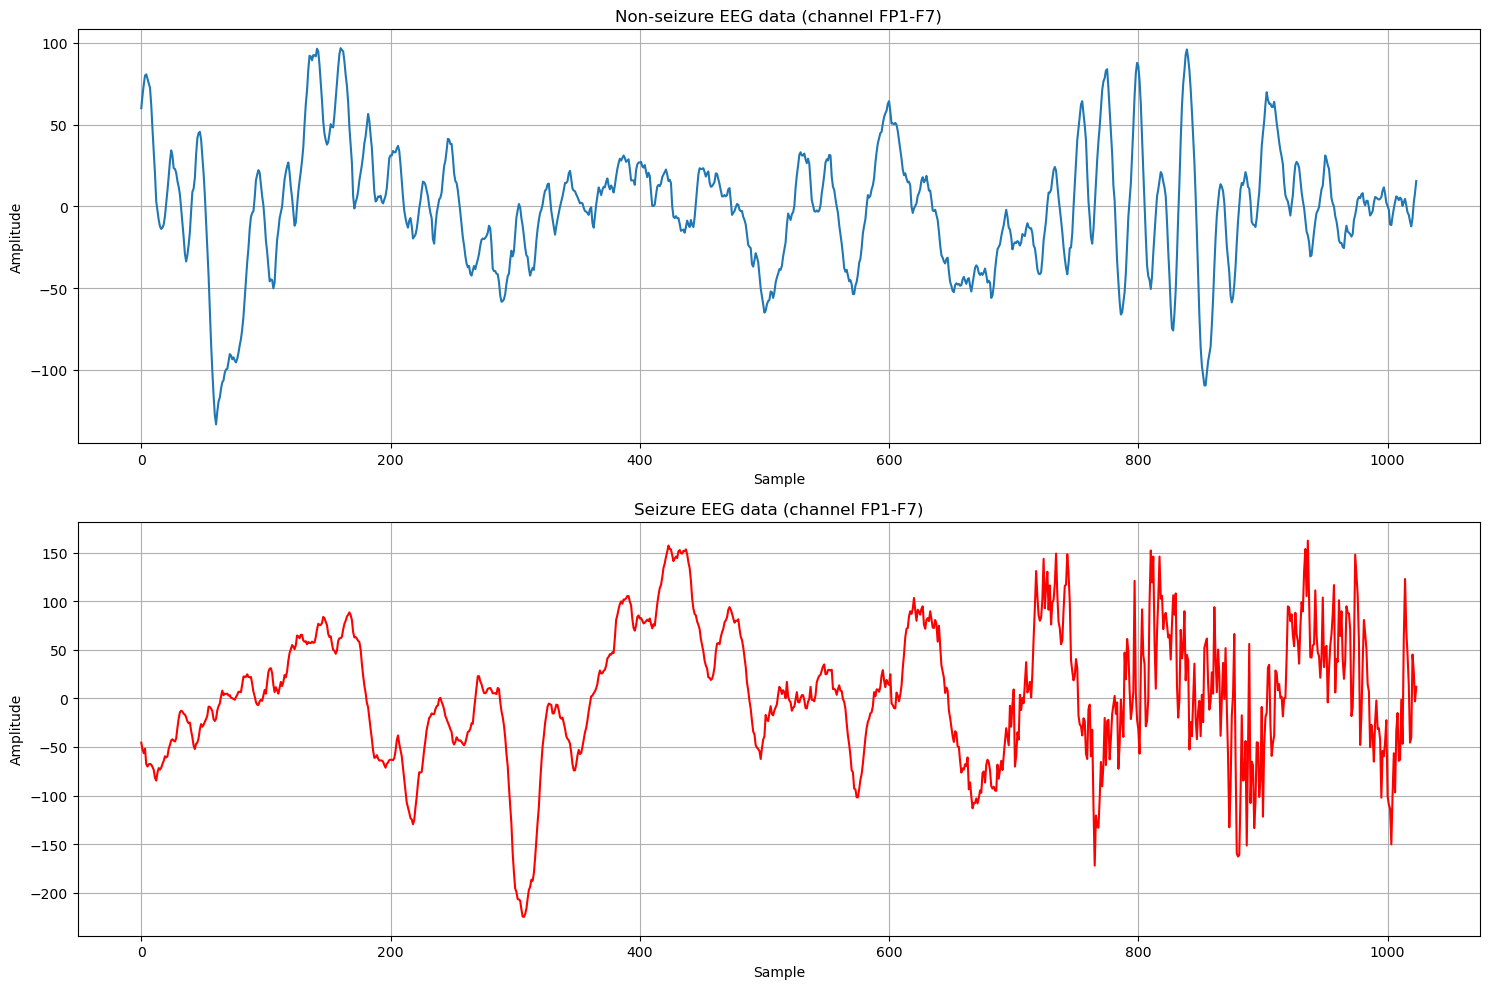


Data Analysis:
Non-seizure stats - Mean: -0.8688, Std: 37.7115
Seizure stats - Mean: 4.1079, Std: 69.0014
Creating preprocessing visualization...


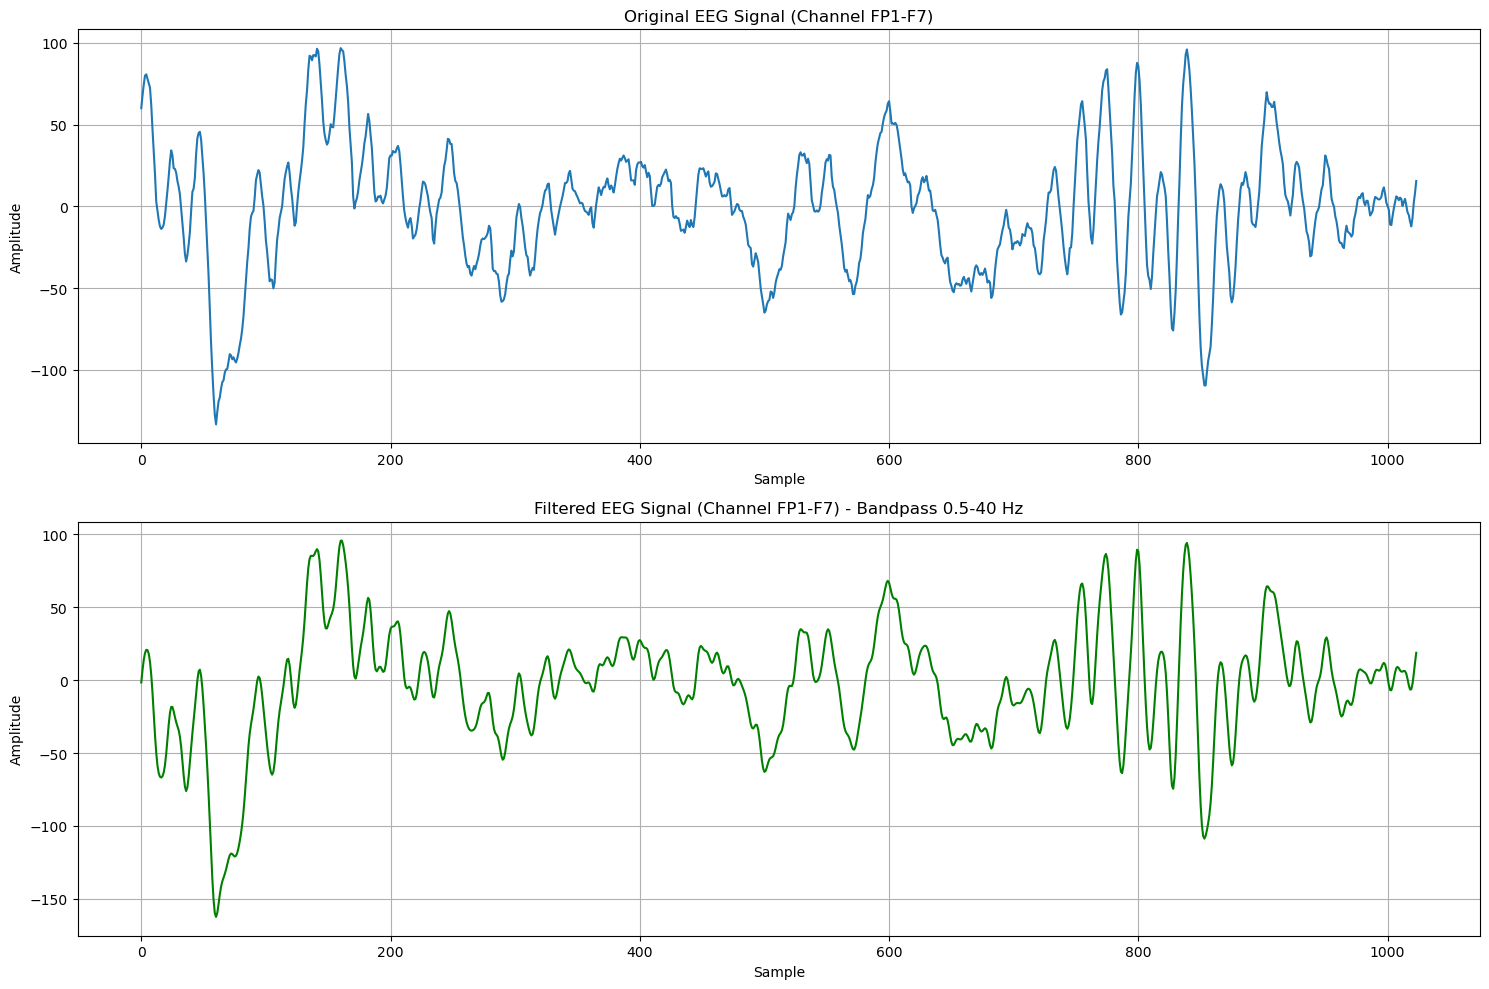

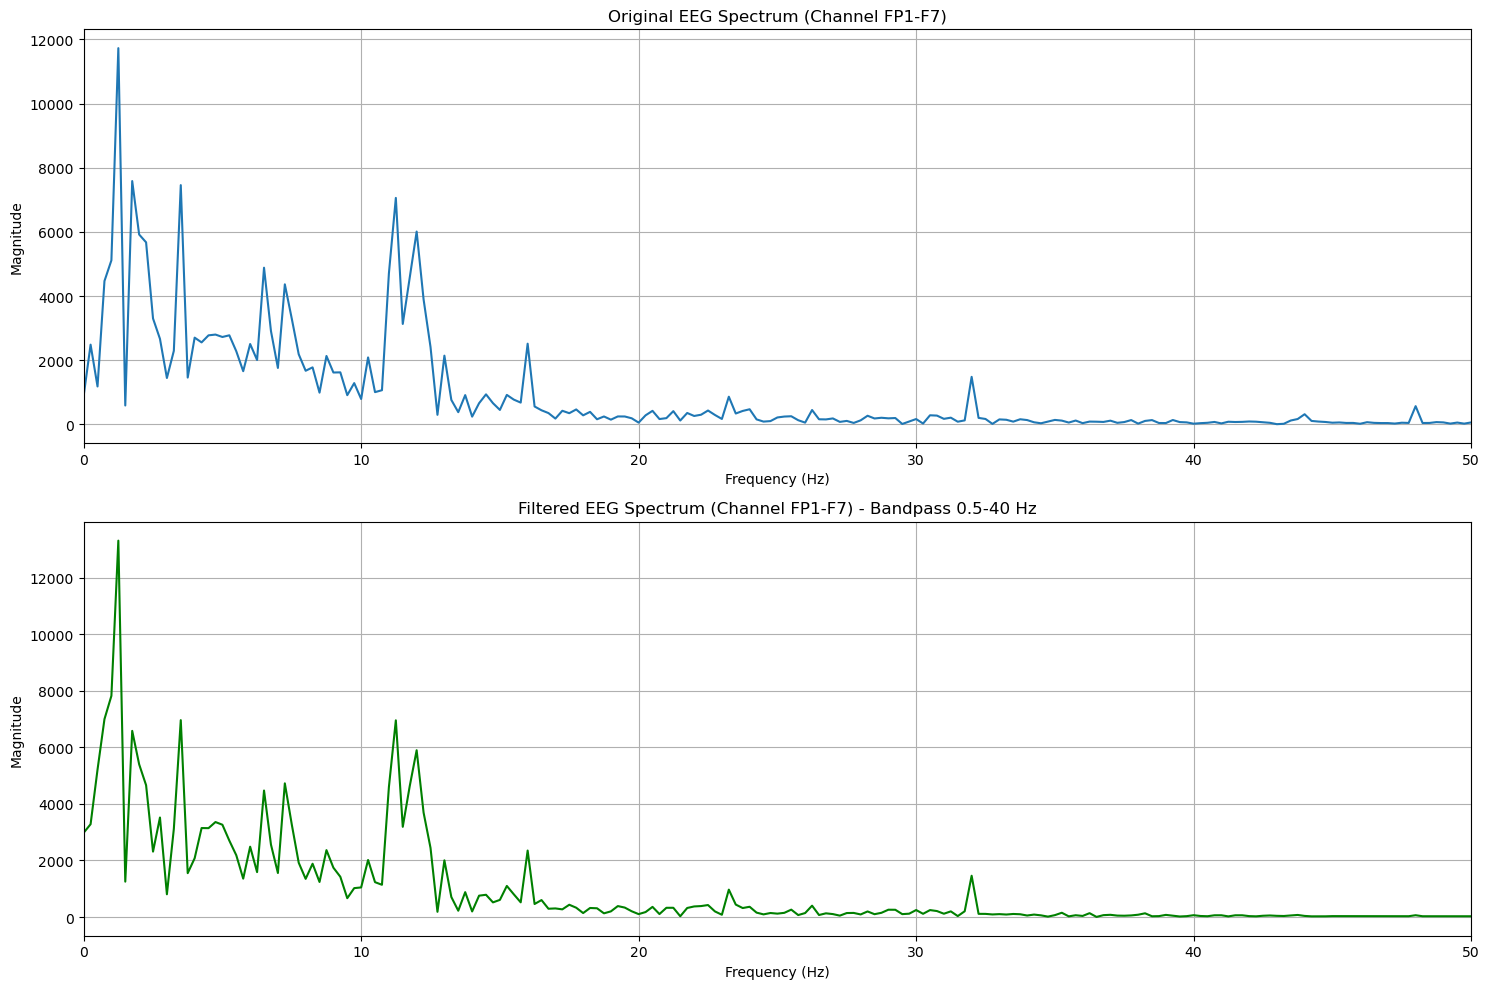


Preprocessing Analysis:
The bandpass filter (0.5-40 Hz) removes noise and focuses on relevant EEG frequency bands:
- Delta (0.5-4 Hz): Associated with deep sleep
- Theta (4-8 Hz): Associated with drowsiness
- Alpha (8-13 Hz): Associated with relaxed wakefulness
- Beta (13-30 Hz): Associated with active thinking
- Gamma (30-40 Hz): Associated with cognitive processing
Displaying feature distributions...


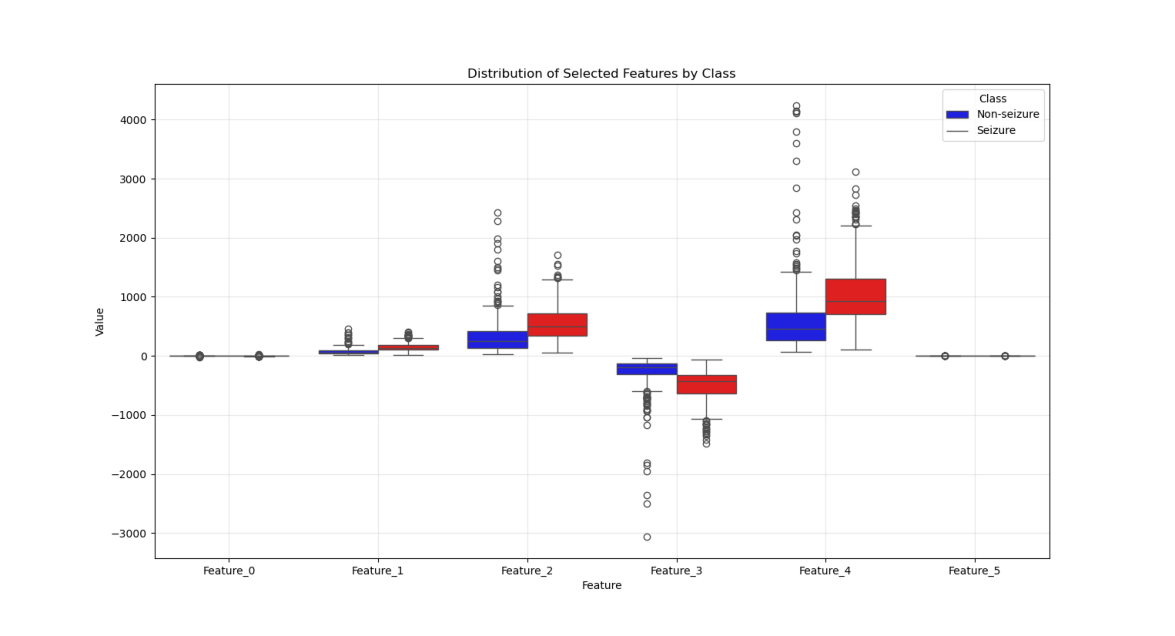


Feature Analysis:
The boxplots show the distribution of key features by class (seizure vs. non-seizure).
Features that show clear separation between classes are most useful for classification.
The correlation matrix helps identify redundant features that can be removed.
Displaying standardization effect...


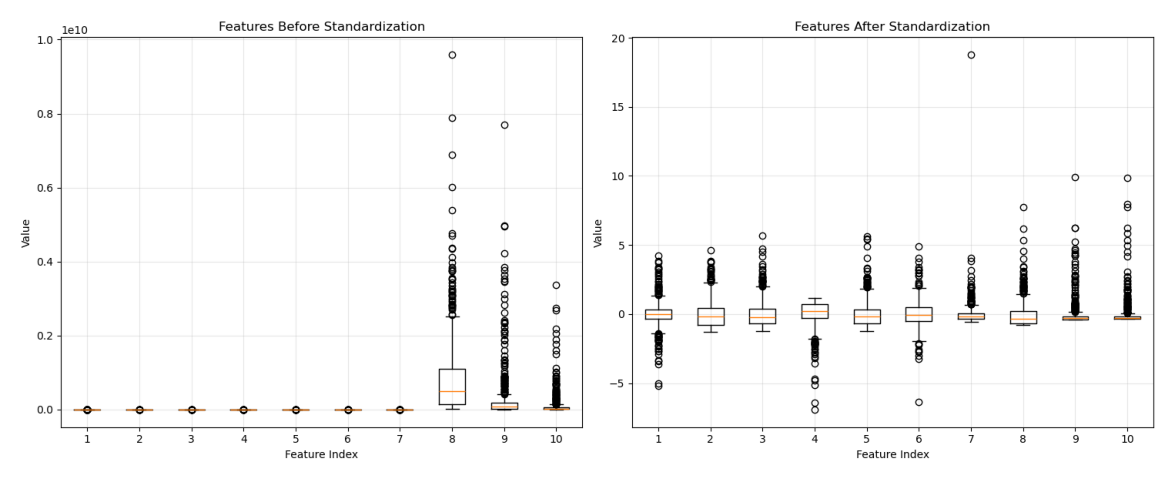


Standardization Analysis:
Standardization transforms features to have zero mean and unit variance.
This helps prevent features with large values from dominating the model training.
It also helps improve convergence for algorithms like SVM.
Displaying model evaluation results...


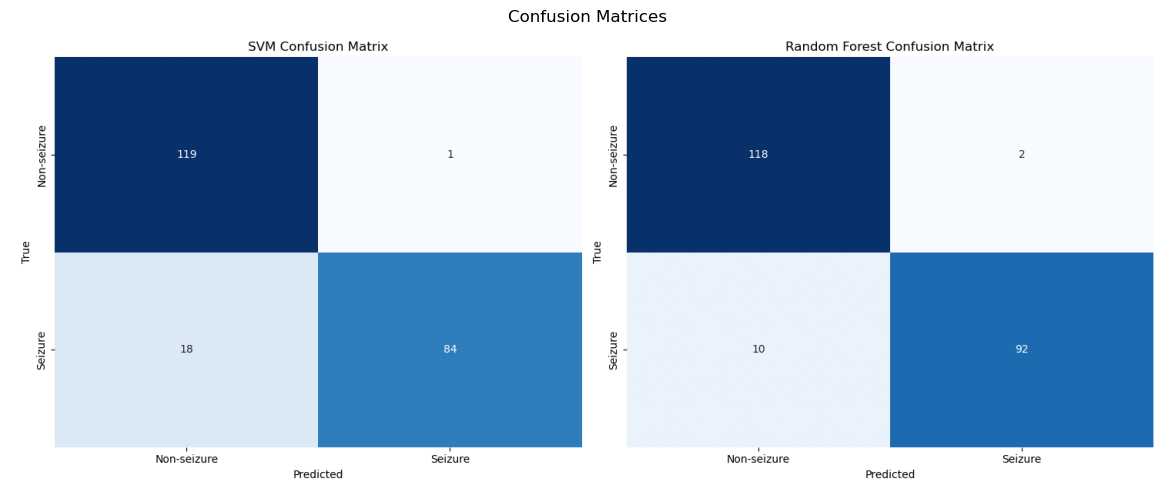

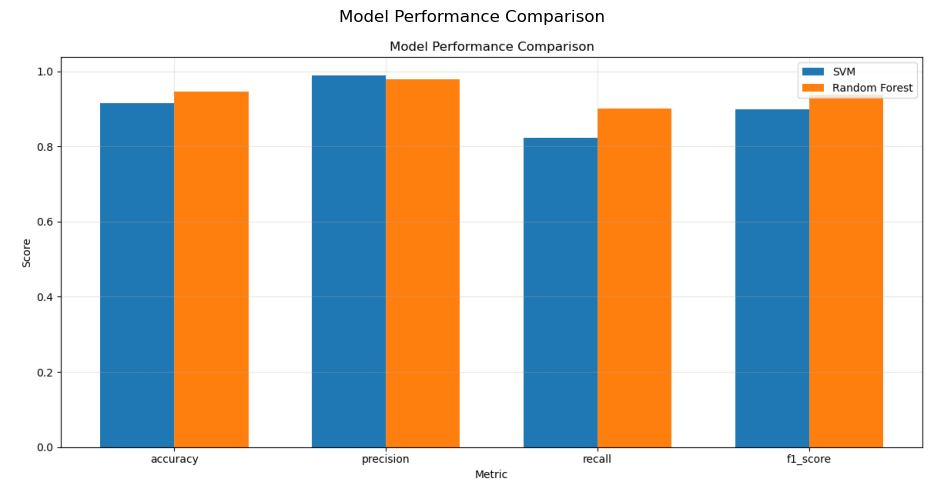


Model Evaluation Analysis:
The confusion matrices show:
- True Positives (TP): Correctly predicted seizure cases
- True Negatives (TN): Correctly predicted non-seizure cases
- False Positives (FP): Non-seizure cases incorrectly predicted as seizure
- False Negatives (FN): Seizure cases incorrectly predicted as non-seizure

Performance metrics:
- Accuracy: Overall correct predictions (TP+TN)/(TP+TN+FP+FN)
- Precision: Correct positive predictions TP/(TP+FP)
- Recall: True positive rate TP/(TP+FN)
- F1-score: Harmonic mean of precision and recall 2*(Precision*Recall)/(Precision+Recall)
Displaying 6 visualizations...


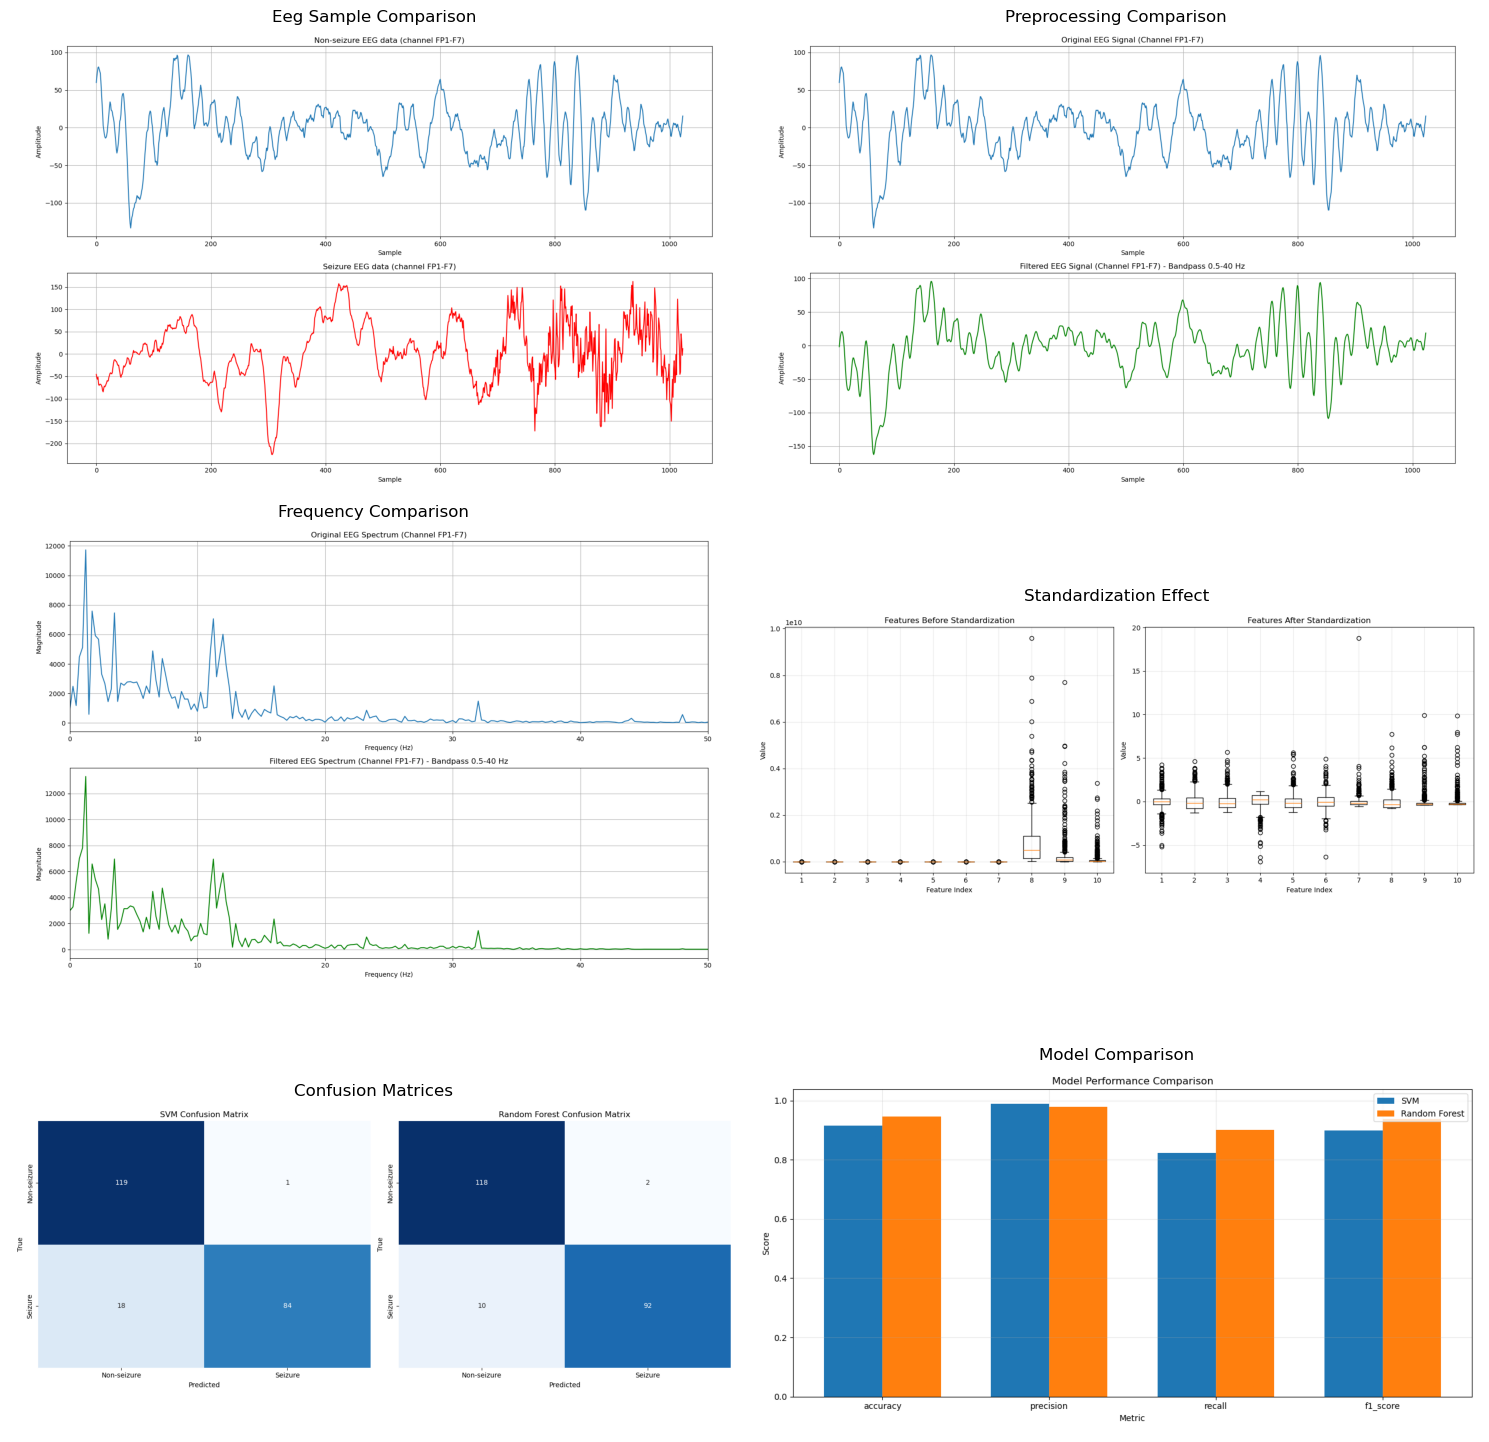


Summary of EEG Seizure Detection Analysis:
1. Data Exploration: Compared raw EEG signals from seizure and non-seizure cases
2. Preprocessing: Applied bandpass filtering to focus on relevant frequency bands
3. Feature Extraction: Extracted time and frequency domain features
4. Standardization: Normalized features for better model performance
5. Model Training: Trained SVM and Random Forest classifiers
6. Evaluation: Compared model performance with various metrics

=== Visualization Complete ===


In [12]:
"""
EEG Seizure Detection Visualization
========================================
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.fft import fft, fftfreq
import os

# Check if visualizations exist
def check_visualization(filename):
    return os.path.exists(filename)

# 1. DATA EXPLORATION VISUALIZATION
def visualize_sample_data(nonseizure_file, seizure_file):
    """Visualize sample EEG data from both classes"""
    print("Creating data exploration visualization...")
    
    # Load sample files
    nonseizure_df = pd.read_csv(nonseizure_file)
    seizure_df = pd.read_csv(seizure_file)
    
    # Plot sample data from both classes
    plt.figure(figsize=(15, 10))
    
    # Plot non-seizure data
    plt.subplot(2, 1, 1)
    channel = nonseizure_df.columns[0]  # First EEG channel
    plt.plot(nonseizure_df[channel][:1024])  # 4 seconds of data (at 256 Hz)
    plt.title(f'Non-seizure EEG data (channel {channel})')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Plot seizure data
    plt.subplot(2, 1, 2)
    plt.plot(seizure_df[channel][:1024], color='red')  # 4 seconds of data
    plt.title(f'Seizure EEG data (channel {channel})')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('eeg_sample_comparison.png')
    plt.show()
    print("\nData Analysis:")
    print(f"Non-seizure stats - Mean: {nonseizure_df[channel][:1024].mean():.4f}, Std: {nonseizure_df[channel][:1024].std():.4f}")
    print(f"Seizure stats - Mean: {seizure_df[channel][:1024].mean():.4f}, Std: {seizure_df[channel][:1024].std():.4f}")

# 2. PREPROCESSING VISUALIZATION
def visualize_preprocessing_effect(data_file):
    """Visualize the effect of preprocessing on EEG data"""
    from scipy import signal
    
    print("Creating preprocessing visualization...")
    
    # Load data
    data = pd.read_csv(data_file)
    channel = data.columns[0]
    
    # Apply bandpass filter
    fs = 256  # Hz
    lowcut = 0.5  # Hz
    highcut = 40  # Hz
    
    # Create bandpass filter
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(6, [low, high], btype='band')
    
    # Apply filter
    filtered_data = pd.DataFrame()
    filtered_data[channel] = signal.filtfilt(b, a, data[channel])
    
    # Visualize in time domain
    plt.figure(figsize=(15, 10))
    
    # Original signal
    plt.subplot(2, 1, 1)
    plt.plot(data[channel][:1024])
    plt.title(f'Original EEG Signal (Channel {channel})')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Filtered signal
    plt.subplot(2, 1, 2)
    plt.plot(filtered_data[channel][:1024], color='green')
    plt.title(f'Filtered EEG Signal (Channel {channel}) - Bandpass 0.5-40 Hz')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('preprocessing_comparison.png')
    plt.show()
    
    # Visualize in frequency domain
    plt.figure(figsize=(15, 10))
    
    # Convert pandas Series to numpy arrays
    original_signal = data[channel][:1024].to_numpy()
    filtered_signal = filtered_data[channel][:1024].to_numpy()
    
    # Compute FFT for original signal
    original_fft = fft(original_signal)
    original_fft_mag = np.abs(original_fft)[:1024//2]
    freqs = fftfreq(1024, 1/fs)[:1024//2]
    
    # Compute FFT for filtered signal
    filtered_fft = fft(filtered_signal)
    filtered_fft_mag = np.abs(filtered_fft)[:1024//2]
    
    # Original signal spectrum
    plt.subplot(2, 1, 1)
    plt.plot(freqs, original_fft_mag)
    plt.title(f'Original EEG Spectrum (Channel {channel})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim([0, 50])
    plt.grid(True)
    
    # Filtered signal spectrum
    plt.subplot(2, 1, 2)
    plt.plot(freqs, filtered_fft_mag, color='green')
    plt.title(f'Filtered EEG Spectrum (Channel {channel}) - Bandpass 0.5-40 Hz')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim([0, 50])
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('frequency_comparison.png')
    plt.show()
    
    print("\nPreprocessing Analysis:")
    print("The bandpass filter (0.5-40 Hz) removes noise and focuses on relevant EEG frequency bands:")
    print("- Delta (0.5-4 Hz): Associated with deep sleep")
    print("- Theta (4-8 Hz): Associated with drowsiness")
    print("- Alpha (8-13 Hz): Associated with relaxed wakefulness")
    print("- Beta (13-30 Hz): Associated with active thinking")
    print("- Gamma (30-40 Hz): Associated with cognitive processing")

# 3. FEATURE EXTRACTION VISUALIZATION
def visualize_feature_distributions():
    """Visualize feature distributions using existing files"""
    if not check_visualization('feature_distributions.png'):
        print("Feature distribution visualization not found. Run the main pipeline first.")
        return
    
    print("Displaying feature distributions...")
    plt.figure(figsize=(15, 8))
    img = plt.imread('feature_distributions.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    """if check_visualization('feature_correlation.png'):
        plt.figure(figsize=(12, 10))
        img = plt.imread('feature_correlation.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()"""
    
    print("\nFeature Analysis:")
    print("The boxplots show the distribution of key features by class (seizure vs. non-seizure).")
    print("Features that show clear separation between classes are most useful for classification.")
    print("The correlation matrix helps identify redundant features that can be removed.")

# 4. STANDARDIZATION VISUALIZATION
def visualize_standardization_effect():
    """Visualize the effect of standardization"""
    if not check_visualization('standardization_effect.png'):
        print("Standardization visualization not found. Run the main pipeline first.")
        return
    
    print("Displaying standardization effect...")
    plt.figure(figsize=(15, 6))
    img = plt.imread('standardization_effect.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    print("\nStandardization Analysis:")
    print("Standardization transforms features to have zero mean and unit variance.")
    print("This helps prevent features with large values from dominating the model training.")
    print("It also helps improve convergence for algorithms like SVM.")

# 5. MODEL EVALUATION VISUALIZATION
def visualize_model_results():
    """Visualize model evaluation results"""
    if not check_visualization('confusion_matrices.png') or not check_visualization('model_comparison.png'):
        print("Model evaluation visualizations not found. Run the main pipeline first.")
        return
    
    print("Displaying model evaluation results...")
    
    # Confusion matrices
    plt.figure(figsize=(15, 6))
    img = plt.imread('confusion_matrices.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title("Confusion Matrices")
    plt.show()
    
    # Model comparison
    plt.figure(figsize=(12, 6))
    img = plt.imread('model_comparison.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title("Model Performance Comparison")
    plt.show()
    
    print("\nModel Evaluation Analysis:")
    print("The confusion matrices show:")
    print("- True Positives (TP): Correctly predicted seizure cases")
    print("- True Negatives (TN): Correctly predicted non-seizure cases")
    print("- False Positives (FP): Non-seizure cases incorrectly predicted as seizure")
    print("- False Negatives (FN): Seizure cases incorrectly predicted as non-seizure")
    print("\nPerformance metrics:")
    print("- Accuracy: Overall correct predictions (TP+TN)/(TP+TN+FP+FN)")
    print("- Precision: Correct positive predictions TP/(TP+FP)")
    print("- Recall: True positive rate TP/(TP+FN)")
    print("- F1-score: Harmonic mean of precision and recall 2*(Precision*Recall)/(Precision+Recall)")

# 6. DISPLAY ALL VISUALIZATIONS
def display_all_visualizations():
    """Display all available visualizations in a single figure"""
    visualizations = [
        'eeg_sample_comparison.png',
        'preprocessing_comparison.png',
        'frequency_comparison.png', 
        #'feature_distributions.png',
        'standardization_effect.png',
        'confusion_matrices.png',
        'model_comparison.png'
    ]
    
    available_viz = [viz for viz in visualizations if check_visualization(viz)]
    
    if not available_viz:
        print("No visualizations found. Run the main pipeline first.")
        return
    
    print(f"Displaying {len(available_viz)} visualizations...")
    
    # Create a grid of subplots based on the number of available visualizations
    n_viz = len(available_viz)
    n_cols = 2
    n_rows = (n_viz + 1) // n_cols
    
    plt.figure(figsize=(15, 5*n_rows))
    
    for i, viz_file in enumerate(available_viz):
        plt.subplot(n_rows, n_cols, i+1)
        img = plt.imread(viz_file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(viz_file.replace('.png', '').replace('_', ' ').title())
    
    plt.tight_layout()
    plt.savefig('all_visualizations.png')
    plt.show()
    
    print("\nSummary of EEG Seizure Detection Analysis:")
    print("1. Data Exploration: Compared raw EEG signals from seizure and non-seizure cases")
    print("2. Preprocessing: Applied bandpass filtering to focus on relevant frequency bands")
    print("3. Feature Extraction: Extracted time and frequency domain features")
    print("4. Standardization: Normalized features for better model performance")
    print("5. Model Training: Trained SVM and Random Forest classifiers")
    print("6. Evaluation: Compared model performance with various metrics")

# Main function to call all visualization functions
def run_visualizations(nonseizure_file='data/nonseizure/sample_chb01_0.csv', 
                        seizure_file='data/seizure/sample_chb01_0.csv'):
    """Run all visualization functions"""
    print("=== EEG Seizure Detection Visualization ===\n")
    
    # 1. Data Exploration
    visualize_sample_data(nonseizure_file, seizure_file)
    
    # 2. Preprocessing
    visualize_preprocessing_effect(nonseizure_file)
    
    # 3. Feature Extraction
    visualize_feature_distributions()
    
    # 4. Standardization
    visualize_standardization_effect()
    
    # 5. Model Evaluation
    visualize_model_results()
    
    # 6. All Visualizations
    display_all_visualizations()
    
    print("\n=== Visualization Complete ===")

# Run all visualizations
run_visualizations()

# Or run individual visualizations as needed:
# visualize_sample_data('data/nonseizure/sample_chb01_0.csv', 'data/seizure/sample_chb01_0.csv')
# visualize_preprocessing_effect('data/nonseizure/sample_chb01_0.csv')
# visualize_feature_distributions()
# visualize_standardization_effect()
# visualize_model_results()
# display_all_visualizations()

Random Forest classifier outperformed the SVM model across all metrics:

Random Forest Results:

Accuracy: 0.9459 (94.59%)
Precision: 0.9787 (97.87%)
Recall: 0.9020 (90.20%)
F1 Score: 0.9388 (93.88%)


SVM Results:

Accuracy: 0.9144 (91.44%)
Precision: 0.9882 (98.82%)
Recall: 0.8235 (82.35%)
F1 Score: 0.8984 (89.84%)



Looking at the confusion matrices:

Random Forest missed fewer seizures (10 false negatives vs. 18 in SVM)
Both models had very few false positives (2 for Random Forest, 1 for SVM)


In seizure detection, missing a seizure (false negative) is generally more problematic than a false alarm.
Random Forest's higher recall means it's better at detecting actual seizures.
Both models show excellent precision, meaning when they predict a seizure, they're almost always correct.
Overall, the Random Forest model provides a better balance of detecting seizures correctly while minimizing false alarms.

**Refrences:**

https://docs.scipy.org/doc/scipy/reference/signal.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

SVM classifier: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Evaluation metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html


